In [17]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters

import sys
sys.path.append(r'../src/')

In [2]:
import importlib
import transform
importlib.reload(transform)

<module 'transform' from '../src\\transform.py'>

In [3]:
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[7])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

D:/Data/bujo_sample\20190309_125153.jpg


c:\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


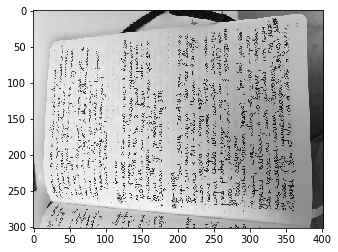

In [4]:
src2 = skimage.transform.rescale(src, scale=0.1)
plt.imshow(src2, cmap='gray')

In [5]:
res = transform.get_text_angle(src2)
print(res[0][0])

c:\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1.11662531017


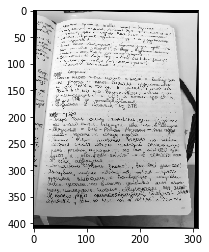

In [6]:
src3 = skimage.transform.rotate(src2, -90.0-res[0][0], resize=True)
plt.imshow(src3, cmap='gray')

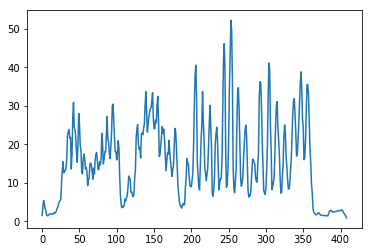

In [7]:
src3v = np.sum(np.abs(src3[:,1:]-src3[:,:-1]), axis=1)
plt.plot(src3v)

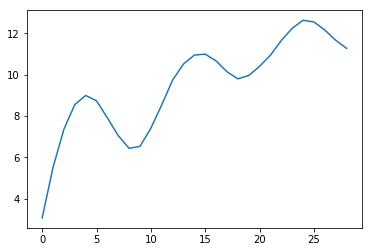

In [8]:
src4 = np.array([np.mean(np.abs(src3v[i:]-src3v[:-i])) for i in range(1, 30)])
plt.plot(src4)

In [10]:
loc_maximas = np.array(range(len(src4)))[np.r_[True, src4[1:] < src4[:-1]] & np.r_[src4[:-1] < src4[1:], True]]
best_freq = min([x for x in loc_maximas if x > 0])
print(best_freq)

8


In [11]:
src5 = src3v - np.median(src3v)
loc_maximas = np.array(range(len(src5)))[np.r_[True, src5[1:] > src5[:-1]] & np.r_[src5[:-1] > src5[1:], True] & (src5 > 0)]
print(loc_maximas)

[ 28  36  38  42  49  56  65  73  77  80  87  95  99 102 128 131 134 139
 148 152 155 161 163 168 170 178 194 206 215 225 234 244 253 263 273 283
 292 304 315 325 338 347 355]


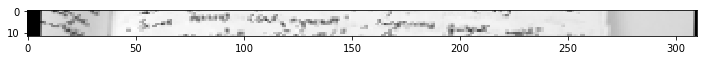

In [12]:
plt.figure(figsize=(12,2))
plt.imshow(src3[60:72,:], cmap='gray')

In [13]:
def calc_haar_feature_v(rows, filter_height=12, filter_width=4, h1=3, h2=8):
    tmpd = np.abs(rows[1:,:]-rows[:-1,:])
    tmp1 = np.mean(tmpd[:h1], axis=0)
    tmp2 = np.mean(tmpd[h1:h2], axis=0)
    tmp3 = np.mean(tmpd[h2:], axis=0)
    tmpr = np.array([(np.median(tmp1[i:(i+filter_width)]), np.median(tmp2[i:(i+filter_width)]), np.median(tmp3[i:(i+filter_width)])) for i in range(len(tmp1)-filter_width)])
    tmpf = (tmpr[:,1] / (np.maximum(tmpr[:,0], tmpr[:,2]) + 0.1))
    return tmpf

def calc_haar_feature_h(img, filter_height=4, filter_width=4):
    tmp = np.abs(img[:,1:]-img[:,:-1])
    tmpf = np.zeros_like(tmp[:,filter_width:])
    for i in range(filter_width):
        if i == filter_width - 1:
            tmpf = tmpf + tmp[:, (i+1):]
        else:
            tmpf = tmpf + tmp[:,(i+1):(-filter_width+i+1)]
    return np.array([np.median(tmpf[i:(i+filter_height), :], axis=0) for i in range(len(tmpf)-filter_height)])

def restore_img(flt, f_w, f_h):
    (sz_h, sz_w) = flt.shape
    res = np.zeros((sz_h+f_h, sz_w+f_w))
    for i in range(f_h):
        for j in range(f_w):
            res[i:(i+sz_h),j:(j+sz_w)] = res[i:(i+sz_h),j:(j+sz_w)] + flt
    return res/(f_w*f_h)

def calc_haar_feature(rows, filter_height=12, filter_width=4, h1=3, h2=8):
    tmpd = np.abs(rows[1:,:]-rows[:-1,:])
    tmpq = np.median(np.abs(rows[h1:h2,1:]-rows[h1:h2,:-1]), axis=0)
    tmpq2 = np.cumsum(tmpq)
    tmpq3 = tmpq2[(filter_width-1):]-tmpq2[:-(filter_width-1)]
    
    tmp1 = np.mean(tmpd[:h1], axis=0)
    tmp2 = np.mean(tmpd[h1:h2], axis=0)
    tmp3 = np.mean(tmpd[h2:], axis=0)
    tmpr = np.array([(np.median(tmp1[i:(i+filter_width)]),
                      np.median(tmp2[i:(i+filter_width)]),
                      np.median(tmp3[i:(i+filter_width)])) for i in range(len(tmp1)-filter_width)])
    tmpf = (tmpr[:,1]*tmpq3 / (np.maximum(tmpr[:,0], tmpr[:,2]) + 0.01))
    return tmpf


In [14]:
%%time
#res_v = [calc_haar_feature_v(src3[i:(i+12)]) for i in range(len(src3)-12)]
#res_h = calc_haar_feature_h(src3, 4, 4)
res = np.array([calc_haar_feature(src3[i:(i+12)]) for i in range(len(src3)-12)])

Wall time: 28.3 s


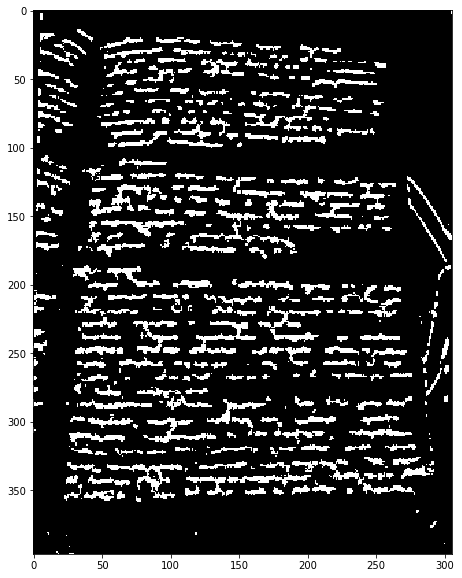

In [131]:
plt.figure(figsize=(14,10))
plt.imshow(res>0.3, cmap='gray')

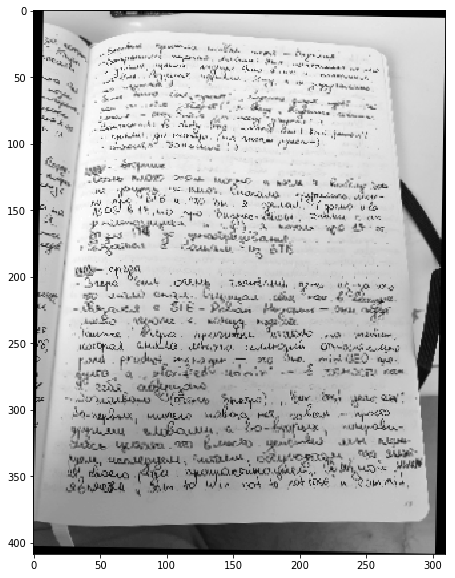

In [124]:
plt.figure(figsize=(14,10))
plt.imshow(src3, cmap='gray')

c:\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


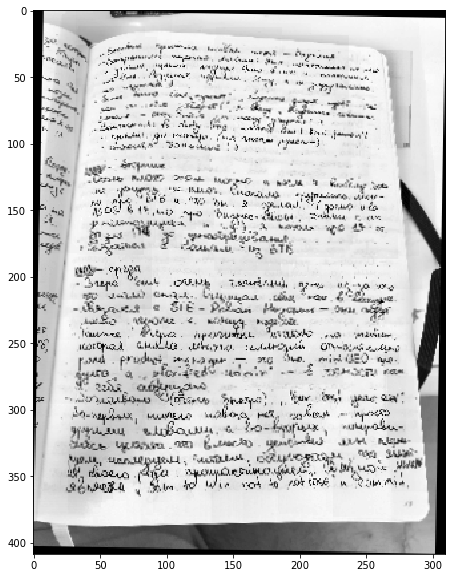

In [31]:
plt.figure(figsize=(14,10))
plt.imshow(skimage.filters.rank.autolevel(src3, np.ones((50,50))), cmap='gray')

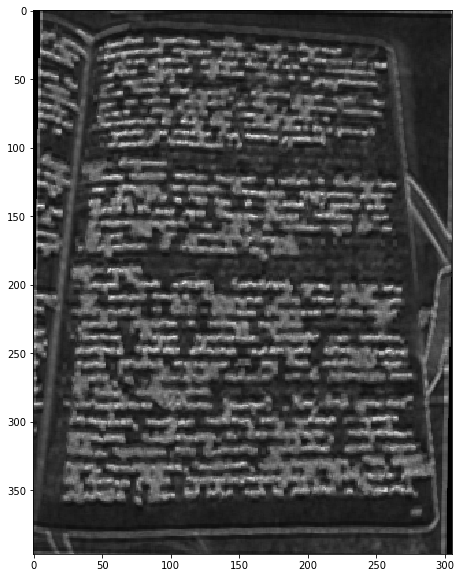

In [36]:
#st1 = (res > 0.3) * 1.0
plt.figure(figsize=(14,10))
plt.imshow(res**0.2, cmap='gray')

In [38]:
tmp0
tmp = (res**0.2-np.min(res**0.2))/(np.max(res**0.2)-np.min(res**0.2))

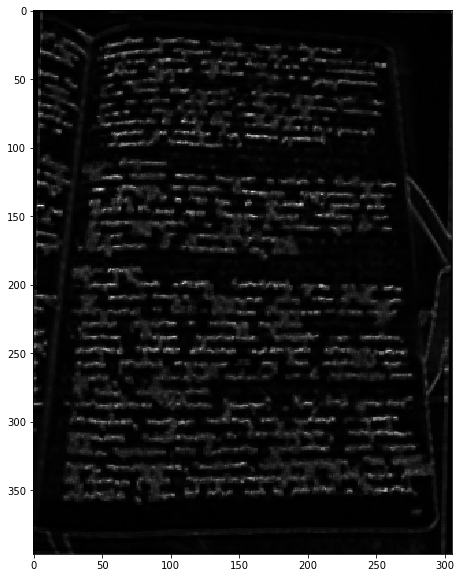

In [44]:
plt.figure(figsize=(14,10))
plt.imshow(res**0.5, cmap='gray')

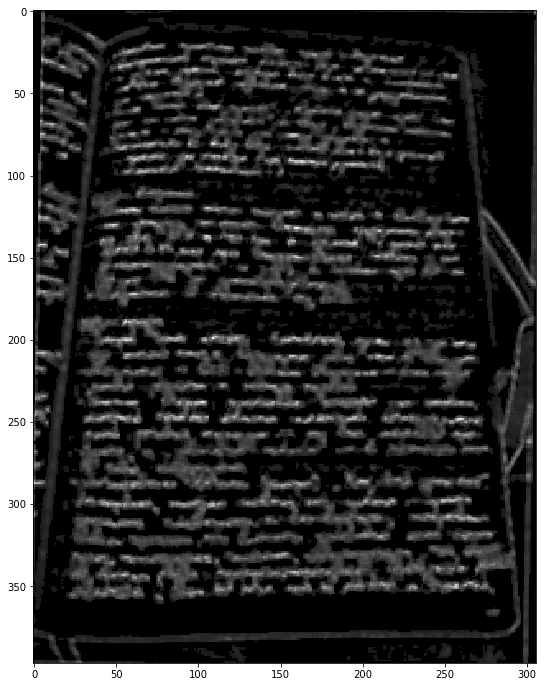

In [65]:
tmp0 = res**0.3
tmp1 = (tmp0 - np.min(tmp0))/(np.max(tmp0) - np.min(tmp0))
tmp1c = np.percentile(tmp0, 10)
tmp1[tmp1 < tmp1c] = 0
plt.figure(figsize=(14,12))
plt.imshow(tmp1, cmap='gray')

In [80]:
am1 = np.argmax(tmp1)
am1i = am1 // tmp1.shape[1]
am1j = am1 % tmp1.shape[1]

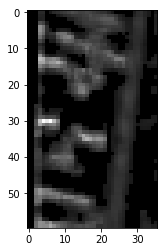

In [86]:
plt.imshow(tmp1[(am1i-30):(am1i+30), 0:(am1j+30)], cmap='gray')

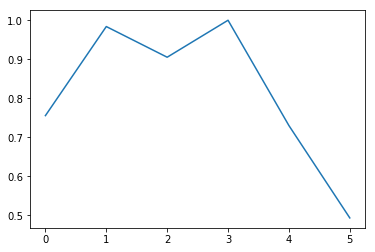

In [95]:
plt.plot(tmp1[am1i, np.array(range(-3,3))+am1j])